<a href="https://colab.research.google.com/github/ketanhdoshi/ml/blob/master/lib/audio_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Audio Processing Examples and Utilities
Basic audio signal processing and using different audio libraries

**Todos**
*   Dis















### Import Libraries

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
# options are 'all', 'none', 'last' and 'last_expr
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import IPython.core.debugger as db
from pathlib import Path
from matplotlib.pyplot import specgram
import numpy as np

In [ ]:
#export
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

### Data Paths for Experimentation

In [ ]:
root_dir = "/content/gdrive/My Drive/Colab Data/"
base_dir = root_dir + 'audio/'

AUDIO_PATH = Path(base_dir) 
AUDIO_FILE = AUDIO_PATH/'keyboard_sample.wav'

### Audio Utilities - Torchaudio

In [ ]:
!pip install torchaudio

In [ ]:
#export

import math, random
import torch
from IPython.display import Audio
try:
  # Import will succeed only if torchaudio has been installed
  import torchaudio
  from torchaudio import transforms
except ImportError as e:
    pass

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
  
  # ----------------------------
  # Show a widget to play the audio sound
  # ----------------------------
  @staticmethod
  def play(aud):
    sig,sr=aud
    display(Audio(data=sig, rate=sr))

  # ----------------------------
  # Pad (or trim) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trim(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Trim the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def signal_shift(aud, max_shift_pct):
    sig,sr = aud
    roll_by = int(random.random()*max_shift_pct*len(sig[0]))
    return (sig.roll(roll_by), sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, spectro_type='mel', n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    f_min, f_max, ws, top_db, pad = 0.0, None, None, 80, 0

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    if (spectro_type == 'mel'):
      spec = transforms.MelSpectrogram(sr, n_fft, ws, hop_len, f_min, f_max, pad, n_mels)(sig)
    elif (spectro_type == 'mfcc'):
      pass
    else: 
      spec = transforms.Spectrogram(n_fft, ws, hop_len, pad, normalize=False)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)


  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape

    # Frequency Masking: frequency channels [f0, f0 + f) are masked. f is chosen from a 
    # uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen 
    # from (0, ν − f) where ν is the number of frequency channels.
    # Time Masking: t consecutive time steps [t0, t0 + t) are masked. t is chosen from a 
    # uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t).

    # Max height of the frequency mask
    F = math.ceil(n_mels * max_mask_pct) # rounding up in case of small %
    # Max width of the time mask
    T = math.ceil(n_steps * max_mask_pct)

    # Create frequency masks
    fill = spec.mean()
    for i in range(0, n_freq_masks):
      f = random.randint(0, F)
      f0 = random.randint(0, n_mels-f)
      spec[0][f0:f0+f] = fill
    
    # Create time masks
    for i in range(0, n_time_masks):
      t = random.randint(0, T)
      t0 = random.randint(0, n_steps-t)
      spec[0][:,t0:t0+t] = fill
    return spec

  # ----------------------------
  # Plot the audio signal
  # ----------------------------
  def show_wave(aud, label='', ax=None):
    sig, sr = aud
    if (not ax):
      _,ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(sig[0])
    ax.set_title(label)

  # ----------------------------
  # Plot the audio signal before and after a transform
  # ----------------------------
  def show_transform(orig, trans):
    osig,osr = orig
    tsig,tsr = trans
    if orig is not None: plt.plot(osig[0], 'm', label="Orig.")
    if trans is not None: plt.plot(tsig[0], 'c', alpha=0.5, label="Transf.")
    plt.legend()
    plt.show()

  # ----------------------------
  # Plot the spectrogram
  # ----------------------------
  def show_spectro(spec, label='', ax=None, figsize=(6,6)):
    if (not ax):
      _,ax = plt.subplots(1, 1, figsize=figsize)
    # Reduce first dimension if it is greyscale
    ax.imshow(spec if (spec.shape[0]==3) else spec.squeeze(0))
    ax.set_title(f'{label}, {list(spec.shape)}')


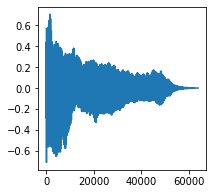

In [ ]:
test_file = AUDIO_FILE
test_aud = AudioUtil.open(test_file)
AudioUtil.play(test_aud)
AudioUtil.show_wave(test_aud)

'Audio is 4.0 seconds'

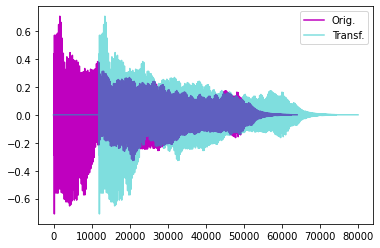

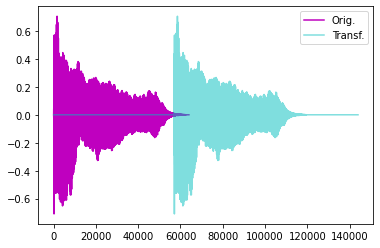

In [ ]:
test_aud_len = test_aud[0].shape[1] / test_aud[1]
f'Audio is {test_aud_len} seconds'

test_trim = AudioUtil.pad_trim(test_aud, max_ms=5000)
AudioUtil.show_transform(test_aud, test_trim)

test_pad = AudioUtil.pad_trim(test_aud, max_ms=9000)
AudioUtil.show_transform(test_aud, test_pad)

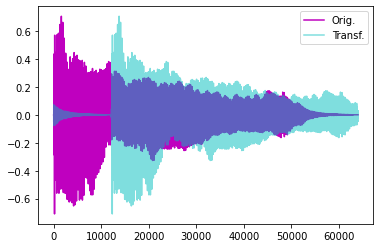

In [ ]:
test_shift = AudioUtil.signal_shift(test_aud, max_shift_pct=0.5)
AudioUtil.show_transform(test_aud, test_shift)

'Tensor shape=torch.Size([1, 64, 126])'

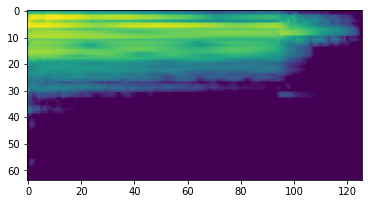

In [ ]:
test_spec = AudioUtil.spectro_gram(test_aud)
AudioUtil.show_spectro(test_spec)

'Tensor shape=torch.Size([1, 64, 126])'

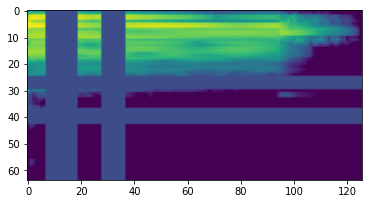

In [ ]:
test_aug = AudioUtil.spectro_augment(test_spec, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
AudioUtil.show_spectro(test_aug)

### Basic Audio Signal Processing with synthetic signal
Generate time domain, frequency domain plots and Spectrograms

In [ ]:
#----------------------------------------------------------------------------
# Simulate 7-second analog sound signal from dialing button keys on a telephone keypad
# The first 3 seconds is the dial key #1 sound, the next 2 seconds is the silence, 
# and the last 3 seconds i the dial key #2 sound.
#
# Every analog telephone button in dial pad generates 2 sine waves. For example, 
# pressing digit 1 button generates the sin waves at frequency 697Hz and 1209Hz. 
# The frequency 697Hz means that the sin wave repeats its fulle cycle 697 times 
# within a second. Two sin waves at two different frequencies mean that the 
# signal is sum of these two waves.
#
# Sampling rate of 4000, meaning that every second, 4000 sample points are taken. 
# This means that there are 28,000 sample points in total.
#----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#-------------------------------
# Generate a sine wave of a given frequency and time duration for a sample rate
# y(t) = A * sin(2 * pi * f * t) is the formula for sine wave
#    A - amplitude, can set it to 1
#    f - frequency and t - time
#-------------------------------
def get_signal_Hz(Hz,sample_rate,length_ts_sec):
    ## 1 sec length time series with sampling rate
    # [0, v1, v2, .... vn] ie. length is number of samples in one sec
    # So the elements in the list corresponds to each sample time
    # Not sure exactly what the v1, v2 values mean but they are based on the
    # frequency and probably correspond to the amplitude of the wave at that
    # point in time, after the sine is generated below
    ts1sec = list(np.linspace(0,np.pi*2*Hz,sample_rate))

    ## 1 sec length time series with sampling rate
    # The list gets duplicated "number of seconds" times 
    # eg. for 3 seconds we get [0, v1, v2, .. vn, 0, v1, v2, ... vn, 0, v1, v2, ...vn]
    ts = ts1sec*length_ts_sec

    # Get the sine of each sample to generate a sine wave
    return(list(np.sin(ts)))

sample_rate   = 4000
length_ts_sec = 3
## --------------------------------- ##
## 3 seconds of "digit 1" sound. Pressing digit 1 buttom generates sine waves at 
# frequency 697Hz and 1209Hz, which are summed together
## --------------------------------- ##
ts1  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts1 += np.array(get_signal_Hz(1209,sample_rate,length_ts_sec))
ts1  = list(ts1)

## -------------------- ##
## 2 seconds of silence
## [0, 0, 0, .....0] ie. length is number of samples
## -------------------- ##
ts_silence = [0]*sample_rate*1

## --------------------------------- ##
## 3 seconds of "digit 2" sound. Pressing digit 2 buttom generates sine waves at 
# frequency 697Hz and 1336Hz, which are summed together
## --------------------------------- ##
ts2  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts2 += np.array(get_signal_Hz(1336,sample_rate,length_ts_sec))
ts2  = list(ts2)

## -------------------- ##
## Add up to 7 seconds
## ------------------- ##
ts = ts1 + ts_silence  + ts2

# Listen to the sound
from IPython.display import Audio
Audio(ts, rate=sample_rate)

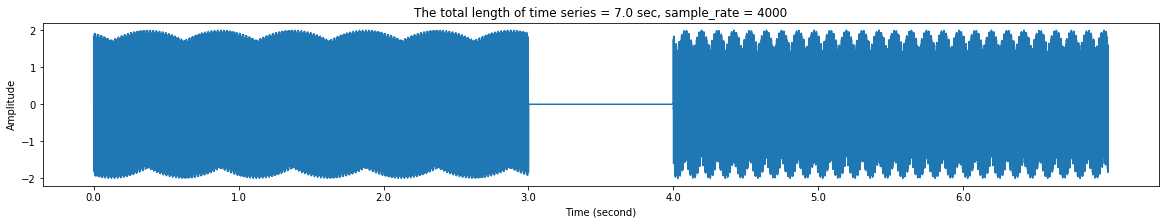

In [ ]:
#-------------------------------
# Generate a sine wave of a given frequency and time duration for a sample rate
# Plot the sound signal in time domain ie. time on X-axis and amplitude on Y-axis
# The plot shows the magnitude of the sounds from amplitudes. However, this time 
# representation of the signal hides frequency infomation, meaning that you cannot 
# tell which frequency waves create this noise pattern.
#-------------------------------
def plot_signal_amplitude (sig, sample_rate):
  total_sig_sec = len(sig)/sample_rate
  plt.figure(figsize=(20,3))
  plt.plot(sig)
  plt.xticks(np.arange(0,len(sig),sample_rate),
            np.arange(0,total_sig_sec,1))
  plt.ylabel("Amplitude")
  plt.xlabel("Time (second)")
  plt.title("The total length of time series = {} sec, sample_rate = {}".format(total_sig_sec, sample_rate))
  plt.show()
  
plot_signal_amplitude (ts, sample_rate)

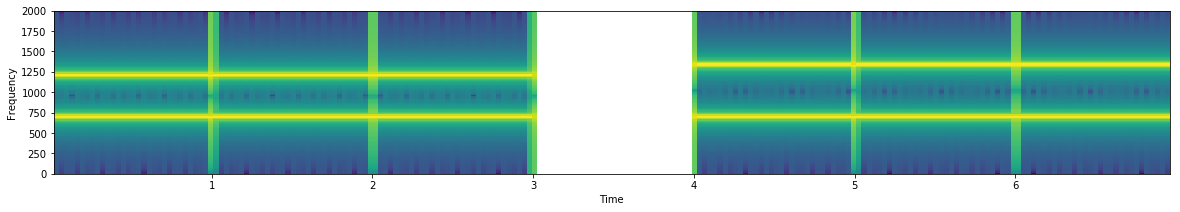

In [ ]:
#-------------------------------
# Plot the Spectrogram. The first 3 seconds contains 697Hz and 1209Hz frequencies, 
# followed by 2 seconds of slience and then the last 3 seconds contains the 693Hz and 1336Hz waves
#-------------------------------
plt.figure(figsize=(20,3))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(ts, Fs=sample_rate)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()   

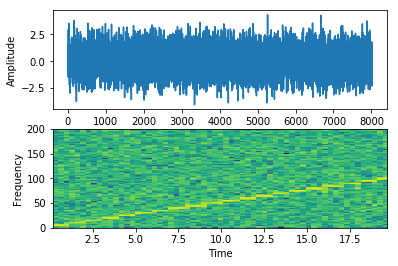

In [ ]:
# Define the list of frequencies
frequencies = np.arange(5,105,5)

# Sampling Frequency
samplingFrequency   = 400

# Create two ndarrays for samples and signal
s1 = np.empty([0]) # For samples
s2 = np.empty([0]) # For signal

# Starting and stopping sample index
start = 1
stop = samplingFrequency+1

for frequency in frequencies:

    sub1 = np.arange(start, stop, 1)

    # Signal - Sine wave with varying frequency + Noise
    sub2 = np.sin(2*np.pi*sub1*frequency*1/samplingFrequency)+np.random.randn(len(sub1))

    s1      = np.append(s1, sub1)
    s2      = np.append(s2, sub2)

    start   = stop+1
    stop    = start+samplingFrequency

# Plot the signal
plt.subplot(211)
plt.plot(s1,s2)
plt.xlabel('Sample')
plt.ylabel('Amplitude')


# Plot the spectrogram
plt.subplot(212)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(s2, Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()   

### Using Librosa

In [ ]:
import librosa
import librosa.display

# Load the audio file
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)
print ('Example shape ', samples.shape, 'Sample rate ', sample_rate)

Example shape  (64000,) Sample rate  16000


#### Display the waveform

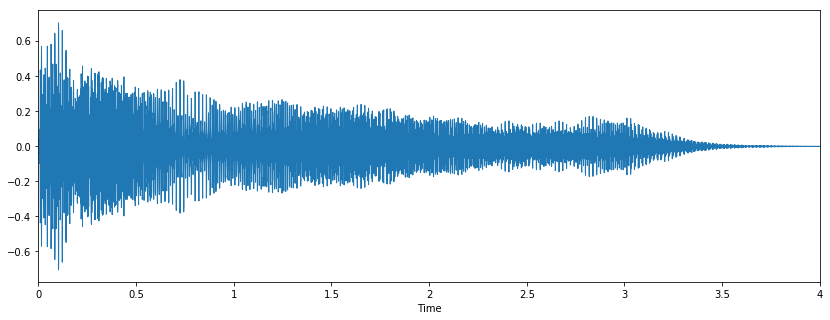

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sample_rate)

#### Spectrogram

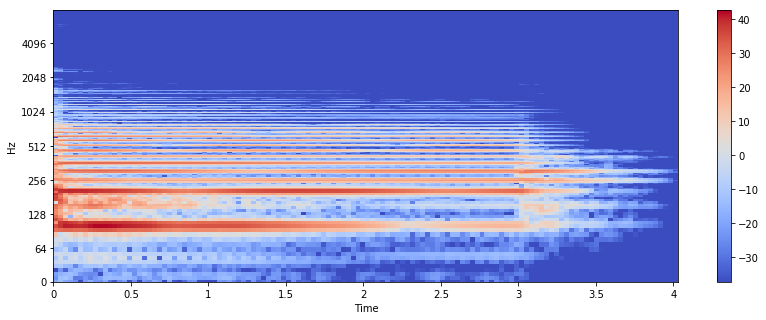

In [ ]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

#### Mel Spectrogram

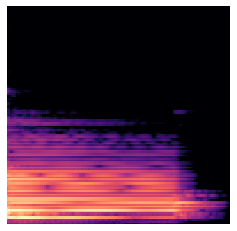

In [ ]:
# Create the figure
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
        
# Generate the spectrogram
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

plt.show()

#### Compute MFCC (Mel Frquency Cepstral Coefficients)

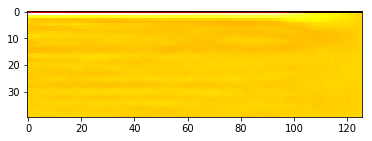

In [ ]:
# Compute MFCC
mfcc = librosa.feature.mfcc(samples, sr=sample_rate, n_mfcc=40)
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

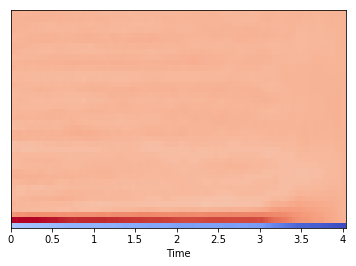

In [ ]:
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')

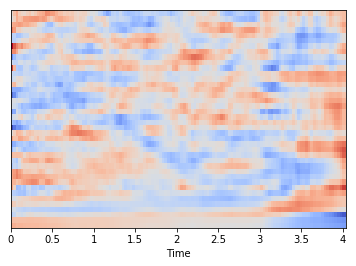

In [ ]:
import sklearn
# scale the MFCCs such that each coefficient dimension has zero mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')

### Using scipy

#### Display waveform

Sampling (frame) rate =  16000
Total samples (frames) =  (64000,)


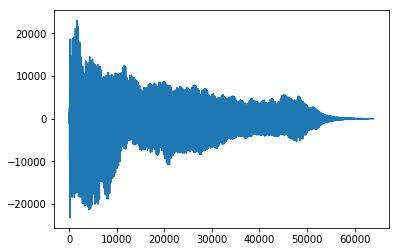

In [ ]:
from scipy.io import wavfile

sample_rate, samples = wavfile.read(AUDIO_FILE)

print("Sampling (frame) rate = ", sample_rate)
print("Total samples (frames) = ", samples.shape)
plt.plot(samples, '-', );

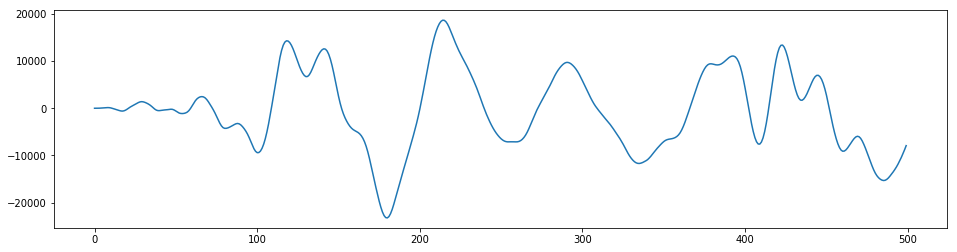

In [ ]:
#---------------------------------------------------------
# Zoom in to one section of the waveform and plot it
#---------------------------------------------------------

plt.figure(figsize=(16, 4))
#plt.plot(samples[:500], '.'); 
plt.plot(samples[:500], '-');

#### Spectrogram

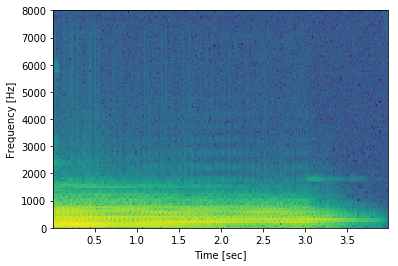

In [ ]:
from scipy import signal
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, np.log(spectrogram))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### Plot Frequency Domain graph

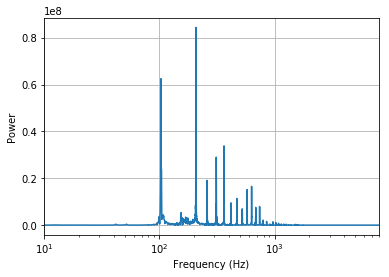

In [ ]:
from scipy.fftpack import fft,fftfreq

# The FFT of the signal
datafft = fft(samples)

# And the power (datafft is of complex dtype)
power = abs(datafft)

# Compute the corresponding DFT frequencies
freqs = fftfreq(samples.shape[0], 1/sample_rate)

plt.xlim( [10, sample_rate/2] )
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.ylabel('Power')
plt.plot(freqs[:int(freqs.size/2)],power[:int(freqs.size/2)])

### Export

In [ ]:
!wget https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py

In [ ]:
from nb_export import notebook2scriptSingle
notebook2scriptSingle(gn_path + '/lib/audio_lib.ipynb', gn_path + '/exp')